# Predicting Loan Approval using Logistic Regression and Naive Bayes

Loans are one of the most significant part of our daily lives today, allowing us to fund activities and purchases like college, cars, houses and more. There are different factors that go into the approval of loans and through this project, we hope to accurately predict loan approval based on various factors. 

# Step 1: Data Exploration

Before we even consider moving into training our models, we should explore our dataset in order to get an idea of how the dataset works.

In [60]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('loan_data.csv')

display(data)
print(data.info())

person_age person_gender person_education  person_income  \
0            22.0        female           Master        71948.0   
1            21.0        female      High School        12282.0   
2            25.0        female      High School        12438.0   
3            23.0        female         Bachelor        79753.0   
4            24.0          male           Master        66135.0   
...           ...           ...              ...            ...   
44995        27.0          male        Associate        47971.0   
44996        37.0        female        Associate        65800.0   
44997        33.0          male        Associate        56942.0   
44998        29.0          male         Bachelor        33164.0   
44999        24.0          male      High School        51609.0   

       person_emp_exp person_home_ownership  loan_amnt        loan_intent  \
0                   0                  RENT    35000.0           PERSONAL   
1                   0                   OWN     1000.0          EDUCATION   
2                   3              MORTGAGE     5500.0            MEDICAL   
3                   0                  RENT    35000.0            MEDICAL   
4                   1                  RENT    35000.0            MEDICAL   
...               ...                   ...        ...                ...   
44995               6                  RENT    15000.0            MEDICAL   
44996              17                  RENT     9000.0    HOMEIMPROVEMENT   
44997               7                  RENT     2771.0  DEBTCONSOLIDATION   
44998               4                  RENT    12000.0          EDUCATION   
44999               1                  RENT     6665.0  DEBTCONSOLIDATION   

       loan_int_rate  loan_percent_income  cb_person_cred_hist_length  \
0              16.02                 0.49                         3.0   
1              11.14                 0.08                         2.0   
2              12.87                 0.44                         3.0   
3              15.23                 0.44                         2.0   
4              14.27                 0.53                         4.0   
...              ...                  ...                         ...   
44995          15.66                 0.31                         3.0   
44996          14.07                 0.14                        11.0   
44997          10.02                 0.05                        10.0   
44998          13.23                 0.36                         6.0   
44999          17.05                 0.13                         3.0   

       credit_score previous_loan_defaults_on_file  loan_status  
0               561                             No            1  
1               504                            Yes            0  
2               635                             No            1  
3               675                             No            1  
4               586                             No            1  
...             ...                            ...          ...  
44995           645                             No            1  
44996           621                             No            1  
44997           668                             No            1  
44998           604                             No            1  
44999           628                             No            1  

[45000 rows x 14 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

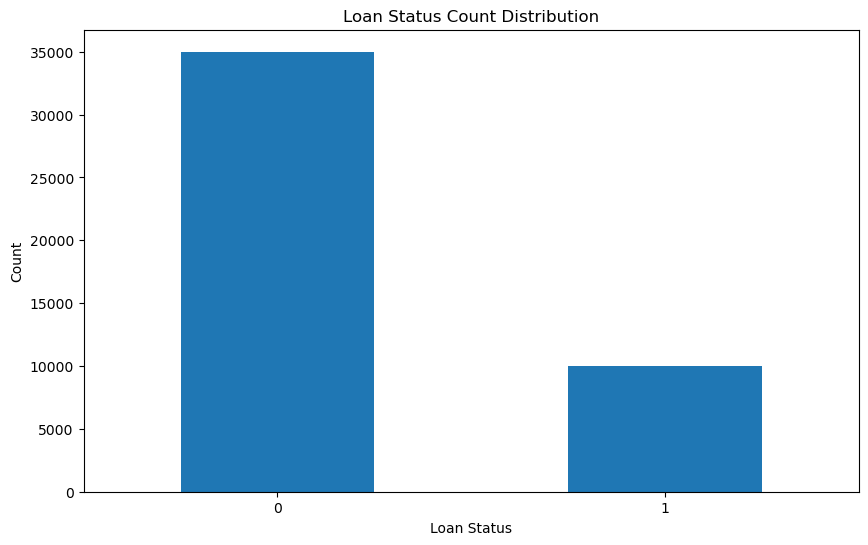

In [62]:
loan_status_counts = data['loan_status'].value_counts()  
loan_status_counts.plot(kind='bar', figsize=(10, 6))  
plt.title('Loan Status Count Distribution')
plt.xlabel('Loan Status')
plt.ylabel('Count')  
plt.xticks(rotation=0)  
plt.show()

With 45000 samples, we can clearly see that there is a skewed amount of approvals vs nonapprovals. In this dataset, around 80% of people were not approved. Next, I would like to approach the problem through credit scores. Credit scores are often touted as the biggest part of our ability to take on debt, so let's analyze how credit scores affect loan approval in this dataset. 

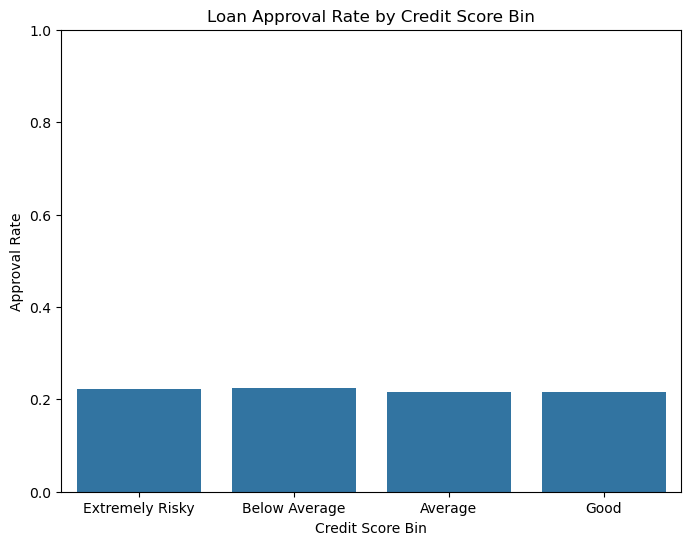

In [65]:
data['credit_score_bin'] = pd.cut(
    data['credit_score'], 
    bins=[300, 579, 669, 739, 850], 
    labels=['Extremely Risky', 'Below Average', 'Average', 'Good']
)

approval_by_credit_bin = data.groupby(
    'credit_score_bin', observed=False
)['loan_status'].mean().reset_index()
approval_by_credit_bin.rename(columns={'loan_status': 'approval_rate'}, inplace=True)

plt.figure(figsize=(8, 6))
sns.barplot(
    x='credit_score_bin', 
    y='approval_rate', 
    data=approval_by_credit_bin
)
plt.title('Loan Approval Rate by Credit Score Bin')
plt.xlabel('Credit Score Bin')
plt.ylabel('Approval Rate')
plt.ylim(0, 1)
plt.show()

While many consider credit scores a significant part of the loan approval process, this dataset seems to show that this could be different than the prevailing theory. Next, let's analyze credit approval rates by income. 

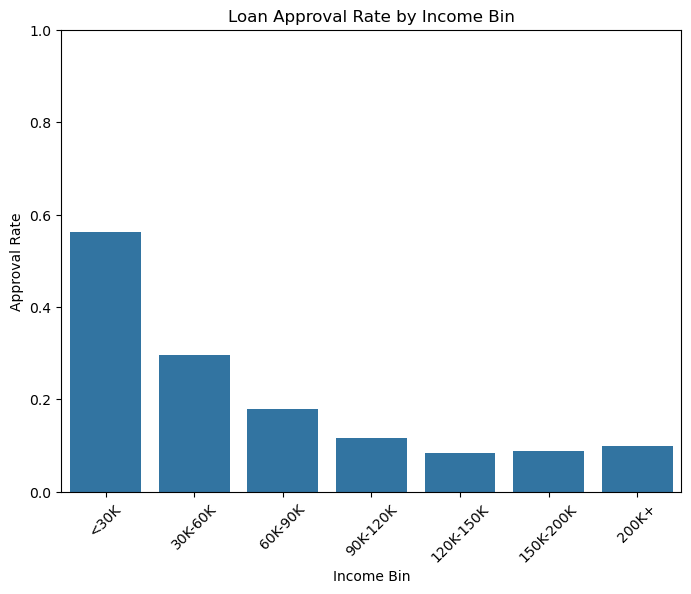

In [68]:
data['income_bin'] = pd.cut(
    data['person_income'], 
    bins=[0, 30000, 60000, 90000, 120000, 150000, 200000, float('inf')], 
    labels=['<30K', '30K-60K', '60K-90K', '90K-120K', '120K-150K', '150K-200K', '200K+']
)

approval_by_income_bin = data.groupby('income_bin', observed = False)['loan_status'].mean().reset_index()
approval_by_income_bin.rename(columns={'loan_status': 'approval_rate'}, inplace=True)

plt.figure(figsize=(8, 6))
sns.barplot(
    x='income_bin', 
    y='approval_rate', 
    data=approval_by_income_bin, 


)
plt.title('Loan Approval Rate by Income Bin')
plt.xlabel('Income Bin')
plt.ylabel('Approval Rate')
plt.xticks(rotation=45)  
plt.ylim(0, 1)
plt.show()

As we can see, loan approval rates actually drop in this dataset as income increases. This might seem contrary to what society might portray about loans, which makes this issue something that could be analyzed through machine learning. Throughout this project, I hope to use machine learning methods to better analyze the chance of loan approval and hopefully shed more light on the complicated process 
of loan approval.

# 1. Logistic Regression

My first ML algorithm is going to be logistic regression. It is often the go-to algorithm for binary classification problems like loan approval. It's an efficient algorithm. It models the probability of an outcome belonging to a specific class based on input features. 

In [72]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

## Step 1. Data Preprocessing

In [75]:
data = pd.read_csv('loan_data.csv')
display(data)
data.isnull().any()


person_age person_gender person_education  person_income  \
0            22.0        female           Master        71948.0   
1            21.0        female      High School        12282.0   
2            25.0        female      High School        12438.0   
3            23.0        female         Bachelor        79753.0   
4            24.0          male           Master        66135.0   
...           ...           ...              ...            ...   
44995        27.0          male        Associate        47971.0   
44996        37.0        female        Associate        65800.0   
44997        33.0          male        Associate        56942.0   
44998        29.0          male         Bachelor        33164.0   
44999        24.0          male      High School        51609.0   

       person_emp_exp person_home_ownership  loan_amnt        loan_intent  \
0                   0                  RENT    35000.0           PERSONAL   
1                   0                   OWN     1000.0          EDUCATION   
2                   3              MORTGAGE     5500.0            MEDICAL   
3                   0                  RENT    35000.0            MEDICAL   
4                   1                  RENT    35000.0            MEDICAL   
...               ...                   ...        ...                ...   
44995               6                  RENT    15000.0            MEDICAL   
44996              17                  RENT     9000.0    HOMEIMPROVEMENT   
44997               7                  RENT     2771.0  DEBTCONSOLIDATION   
44998               4                  RENT    12000.0          EDUCATION   
44999               1                  RENT     6665.0  DEBTCONSOLIDATION   

       loan_int_rate  loan_percent_income  cb_person_cred_hist_length  \
0              16.02                 0.49                         3.0   
1              11.14                 0.08                         2.0   
2              12.87                 0.44                         3.0   
3              15.23                 0.44                         2.0   
4              14.27                 0.53                         4.0   
...              ...                  ...                         ...   
44995          15.66                 0.31                         3.0   
44996          14.07                 0.14                        11.0   
44997          10.02                 0.05                        10.0   
44998          13.23                 0.36                         6.0   
44999          17.05                 0.13                         3.0   

       credit_score previous_loan_defaults_on_file  loan_status  
0               561                             No            1  
1               504                            Yes            0  
2               635                             No            1  
3               675                             No            1  
4               586                             No            1  
...             ...                            ...          ...  
44995           645                             No            1  
44996           621                             No            1  
44997           668                             No            1  
44998           604                             No            1  
44999           628                             No            1  

[45000 rows x 14 columns]

person_age                        False
person_gender                     False
person_education                  False
person_income                     False
person_emp_exp                    False
person_home_ownership             False
loan_amnt                         False
loan_intent                       False
loan_int_rate                     False
loan_percent_income               False
cb_person_cred_hist_length        False
credit_score                      False
previous_loan_defaults_on_file    False
loan_status                       False
dtype: bool

We do not have any null values, so this allows us to move to the next step. 


Training Accuracy: 0.7357
Validation Accuracy: 0.7287
Test Accuracy: 0.7372


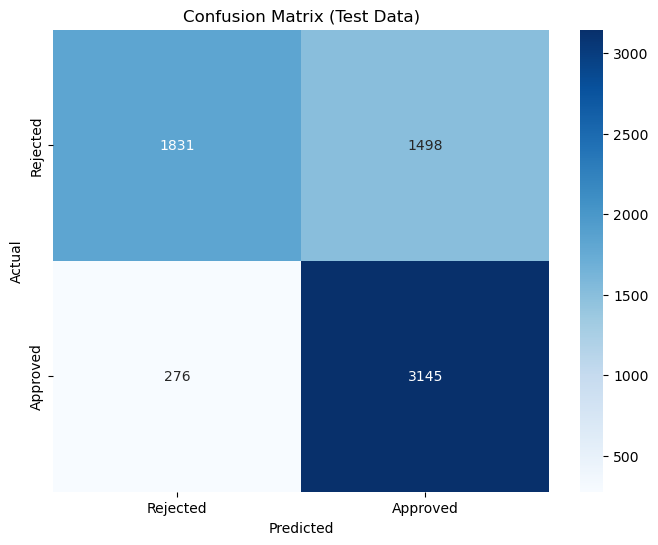


Classification Report (Test Data):
              precision    recall  f1-score   support

       False       0.87      0.55      0.67      3329
        True       0.68      0.92      0.78      3421

    accuracy                           0.74      6750
   macro avg       0.77      0.73      0.73      6750
weighted avg       0.77      0.74      0.73      6750



In [78]:
data = pd.get_dummies(data, drop_first=True)

X = data.iloc[:, :-1]  
y = data.iloc[:, -1] 

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

print(f"\nTraining Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Rejected', 'Approved'],
            yticklabels=['Rejected', 'Approved'])
plt.title("Confusion Matrix (Test Data)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nClassification Report (Test Data):")
print(classification_report(y_test, y_test_pred))



### Results for Our First Run for Logistic Regression

Overall, our model was okay. It had roughly a 74% accuracy and while that isn't bad, it would be disingenous to act as if that is necessarily good. Now, I would like to take steps to improve the accuracy of the model by incorporating other things. However, our validation and training accuracy was very similar which indicates there is close to no overfitting. Additionally, because we hit close to 74%, I believe we also don't see underfitting. 

## LR: Experiment #1: Encoding

If you look at our previous run with logistic regression, one thing I did was dropping any variable that wasn't a number. Now, this was "the easy way out." However, it is possible that by encoding our categorical variables, we can improve the performance of our model. 


Training Accuracy: 0.8555
Validation Accuracy: 0.8594
Test Accuracy: 0.8499


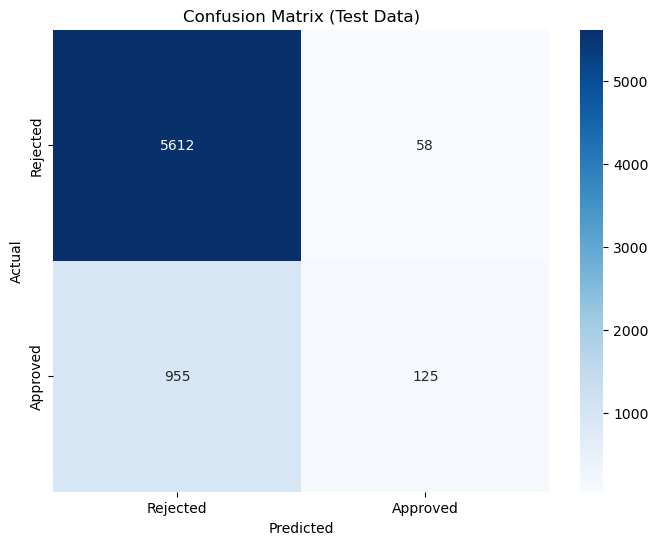


Classification Report (Test Data):
              precision    recall  f1-score   support

       False       0.85      0.99      0.92      5670
        True       0.68      0.12      0.20      1080

    accuracy                           0.85      6750
   macro avg       0.77      0.55      0.56      6750
weighted avg       0.83      0.85      0.80      6750



In [82]:
data = pd.read_csv('loan_data.csv')

from sklearn.preprocessing import LabelEncoder

binary_columns = ['person_gender', 'previous_loan_defaults_on_file']
label_encoder = LabelEncoder()
for col in binary_columns:
    data[col] = label_encoder.fit_transform(data[col])

nominal_columns = ['person_home_ownership', 'loan_intent', 'person_education']
data = pd.get_dummies(data, columns=nominal_columns, drop_first=True)

X = data.iloc[:, :-1]  
y = data.iloc[:, -1] 

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

print(f"\nTraining Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Rejected', 'Approved'],
            yticklabels=['Rejected', 'Approved'])
plt.title("Confusion Matrix (Test Data)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nClassification Report (Test Data):")
print(classification_report(y_test, y_test_pred))

epochs = range(1, 6)
train_acc_sim = [train_accuracy * (1 - 0.01 * i) for i in epochs]
val_acc_sim = [val_accuracy * (1 - 0.02 * i) for i in epochs]


### Results

Overall, our results were much better. The incorporation of the categorical variables definitely improved our overall performance. Based on statistics our performance increased by roughly 10%. However, our model did much worse with True instances, where only 12% were identified. 

## LR: Experiment #2 - Feature Selection
With this dataset in particular, there are quite a lot of different features, which means there is a possiblility that some of these features are redundant or irrelevant. In order to hopefully improve accuracy, I will utilize a correlation matrix to figure out what features might be candidates to be dropped. 

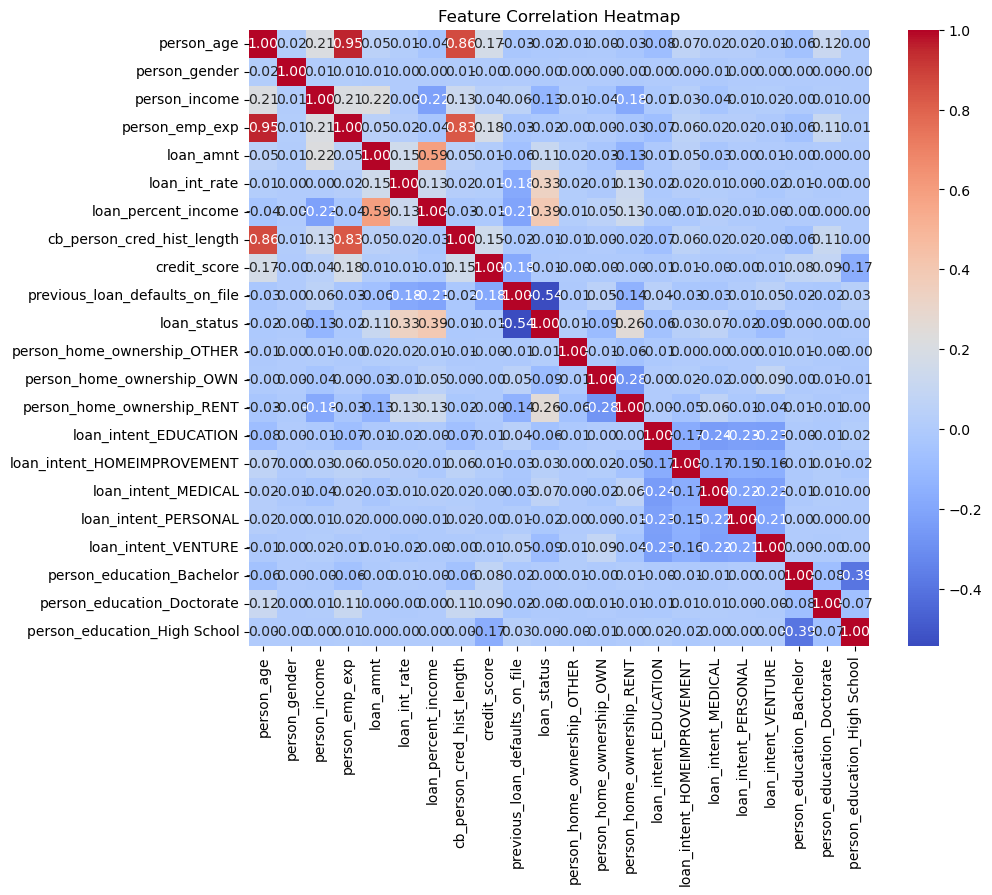

Highly Correlated Features to Drop: ['person_income', 'person_emp_exp', 'loan_amnt', 'loan_percent_income', 'cb_person_cred_hist_length', 'loan_status', 'person_home_ownership_RENT']
Reduced Feature Set Shape: (31500, 15)


person_age  person_gender  person_income  person_emp_exp  loan_amnt  \
0            22.0              0        71948.0               0    35000.0   
1            21.0              0        12282.0               0     1000.0   
2            25.0              0        12438.0               3     5500.0   
3            23.0              0        79753.0               0    35000.0   
4            24.0              1        66135.0               1    35000.0   
...           ...            ...            ...             ...        ...   
44995        27.0              1        47971.0               6    15000.0   
44996        37.0              0        65800.0              17     9000.0   
44997        33.0              1        56942.0               7     2771.0   
44998        29.0              1        33164.0               4    12000.0   
44999        24.0              1        51609.0               1     6665.0   

       loan_int_rate  loan_percent_income  cb_person_cred_hist_length  \
0              16.02                 0.49                         3.0   
1              11.14                 0.08                         2.0   
2              12.87                 0.44                         3.0   
3              15.23                 0.44                         2.0   
4              14.27                 0.53                         4.0   
...              ...                  ...                         ...   
44995          15.66                 0.31                         3.0   
44996          14.07                 0.14                        11.0   
44997          10.02                 0.05                        10.0   
44998          13.23                 0.36                         6.0   
44999          17.05                 0.13                         3.0   

       credit_score  previous_loan_defaults_on_file  ...  \
0               561                               0  ...   
1               504                               1  ...   
2               635                               0  ...   
3               675                               0  ...   
4               586                               0  ...   
...             ...                             ...  ...   
44995           645                               0  ...   
44996           621                               0  ...   
44997           668                               0  ...   
44998           604                               0  ...   
44999           628                               0  ...   

       person_home_ownership_RENT  loan_intent_EDUCATION  \
0                            True                  False   
1                           False                   True   
2                           False                  False   
3                            True                  False   
4                            True                  False   
...                           ...                    ...   
44995                        True                  False   
44996                        True                  False   
44997                        True                  False   
44998                        True                   True   
44999                        True                  False   

       loan_intent_HOMEIMPROVEMENT  loan_intent_MEDICAL  loan_intent_PERSONAL  \
0                            False                False                  True   
1                            False                False                 False   
2                            False                 True                 False   
3                            False                 True                 False   
4                            False                 True                 False   
...                            ...                  ...                   ...   
44995                        False                 True                 False   
44996                         True                False                 False   
44997                 

In [84]:
corr_matrix = pd.DataFrame(X_train, columns=X.columns).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

threshold = 0.2
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print("Highly Correlated Features to Drop:", to_drop)

X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_test_df = pd.DataFrame(X_test, columns=X.columns)
X_val_df = pd.DataFrame(X_val, columns=X.columns)

X_val_reduced = X_val_df.drop(columns=to_drop)
X_train_reduced = X_train_df.drop(columns=to_drop)
X_test_reduced = X_test_df.drop(columns=to_drop)

print("Reduced Feature Set Shape:", X_train_reduced.shape)

display(data)


Training Accuracy: 0.8559
Validation Accuracy: 0.8587
Test Accuracy: 0.8523


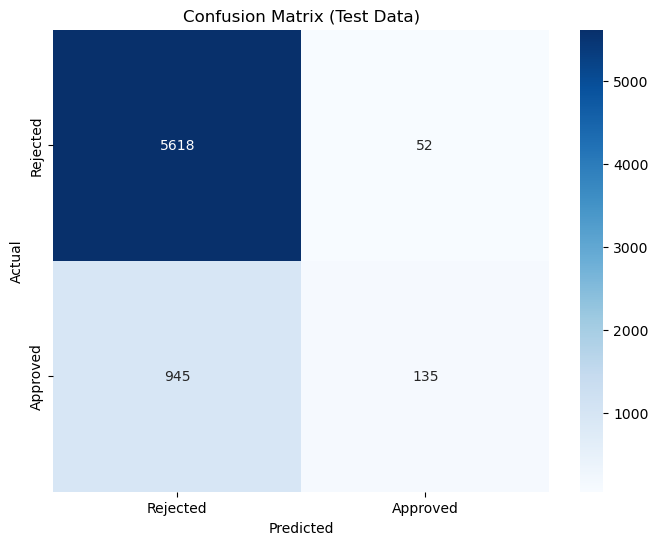


Classification Report (Test Data):
              precision    recall  f1-score   support

       False       0.86      0.99      0.92      5670
        True       0.72      0.12      0.21      1080

    accuracy                           0.85      6750
   macro avg       0.79      0.56      0.57      6750
weighted avg       0.83      0.85      0.81      6750



In [86]:
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_reduced, y_train)

y_train_pred = model.predict(X_train_reduced)
y_val_pred = model.predict(X_val_reduced)

train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nTraining Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

y_test_pred = model.predict(X_test_reduced)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Rejected', 'Approved'],
            yticklabels=['Rejected', 'Approved'])
plt.title("Confusion Matrix (Test Data)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nClassification Report (Test Data):")
print(classification_report(y_test, y_test_pred))


### Results for Experiment #2

Honestly, there was very little improvement with this experiment. This was the highest improvement I could get after adjusting the threshold for something to get dropped. I adjusted the threshold all the way down to 0.2.

# 2. Naive Bayes Model


Training Accuracy (Naive Bayes): 0.5656
Validation Accuracy (Naive Bayes): 0.5652
Test Accuracy (Naive Bayes): 0.5653


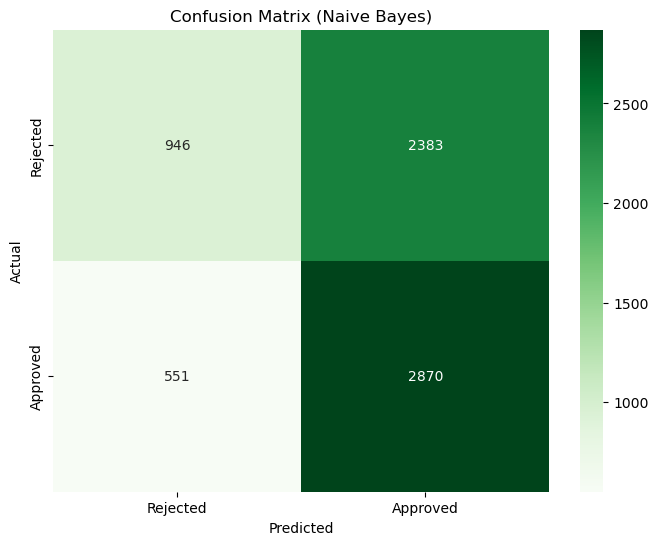


Classification Report (Naive Bayes):
              precision    recall  f1-score   support

       False       0.63      0.28      0.39      3329
        True       0.55      0.84      0.66      3421

    accuracy                           0.57      6750
   macro avg       0.59      0.56      0.53      6750
weighted avg       0.59      0.57      0.53      6750



In [88]:
from sklearn.naive_bayes import GaussianNB
data = pd.read_csv('loan_data.csv')
data = pd.get_dummies(data, drop_first=True)
X = data.iloc[:, :-1]  
y = data.iloc[:, -1] 

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

nb_model = GaussianNB()

nb_model.fit(X_train, y_train)

y_train_pred_nb = nb_model.predict(X_train)
y_val_pred_nb = nb_model.predict(X_val)

train_accuracy_nb = accuracy_score(y_train, y_train_pred_nb)
val_accuracy_nb = accuracy_score(y_val, y_val_pred_nb)

print(f"\nTraining Accuracy (Naive Bayes): {train_accuracy_nb:.4f}")
print(f"Validation Accuracy (Naive Bayes): {val_accuracy_nb:.4f}")

y_test_pred_nb = nb_model.predict(X_test)
test_accuracy_nb = accuracy_score(y_test, y_test_pred_nb)
print(f"Test Accuracy (Naive Bayes): {test_accuracy_nb:.4f}")

conf_matrix_nb = confusion_matrix(y_test, y_test_pred_nb)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_nb, annot=True, fmt="d", cmap="Greens", xticklabels=['Rejected', 'Approved'],
            yticklabels=['Rejected', 'Approved'])
plt.title("Confusion Matrix (Naive Bayes)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nClassification Report (Naive Bayes):")
print(classification_report(y_test, y_test_pred_nb))

### Results from the First Run

Overall, this wasn't good. While the recall for True(approved) loans was pretty good, our overall model only managed a 57% accuracy. This is only marginally better than flipping a coin. This model simply isn't good enough.

## NB: Experiment #1 - Better Encoding

Taking a more nuanced and better approach to encoding helped us out a lot in the logistic regression model. We will implement that here as well. We will be more intentional with our encoding of categorical variables, hoping to improve our performance drastically. 


Training Accuracy (Naive Bayes): 0.8451
Validation Accuracy (Naive Bayes): 0.8487
Test Accuracy (Naive Bayes): 0.8400


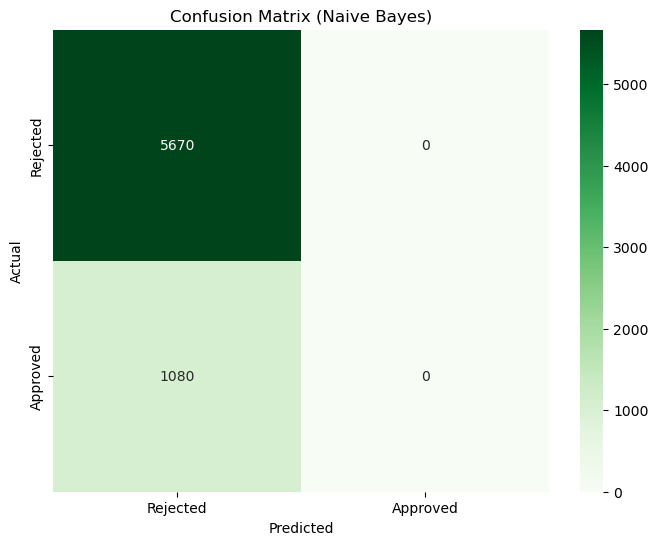


Classification Report (Naive Bayes):
              precision    recall  f1-score   support

       False       0.84      1.00      0.91      5670
        True       1.00      0.00      0.00      1080

    accuracy                           0.84      6750
   macro avg       0.92      0.50      0.46      6750
weighted avg       0.87      0.84      0.77      6750



In [90]:
data = pd.read_csv('loan_data.csv')

binary_columns = ['person_gender', 'previous_loan_defaults_on_file']
label_encoder = LabelEncoder()
for col in binary_columns:
    data[col] = label_encoder.fit_transform(data[col])

nominal_columns = ['person_home_ownership', 'loan_intent', 'person_education']
data = pd.get_dummies(data, columns=nominal_columns, drop_first=True)

X = data.iloc[:, :-1]
y = data.iloc[:, -1]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

y_train_pred = nb_model.predict(X_train)
y_val_pred = nb_model.predict(X_val)

train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

print(f"\nTraining Accuracy (Naive Bayes): {train_accuracy:.4f}")
print(f"Validation Accuracy (Naive Bayes): {val_accuracy:.4f}")

y_test_pred = nb_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy (Naive Bayes): {test_accuracy:.4f}")

conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens", xticklabels=['Rejected', 'Approved'],
            yticklabels=['Rejected', 'Approved'])
plt.title("Confusion Matrix (Naive Bayes)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nClassification Report (Naive Bayes):")
print(classification_report(y_test, y_test_pred, zero_division=1))

### Results for Experiment #1
While the overall was much better, the model seemed incapable to predict any of the true instances. While precison for True might be 1.00, this is misleading because it actually did not predict anything. The next step is to fix this through class balancing.

## Experiment #2 - Class Balancing


Training Accuracy (Naive Bayes): 0.8290
Validation Accuracy (Naive Bayes): 0.8345
Test Accuracy (Naive Bayes): 0.8255


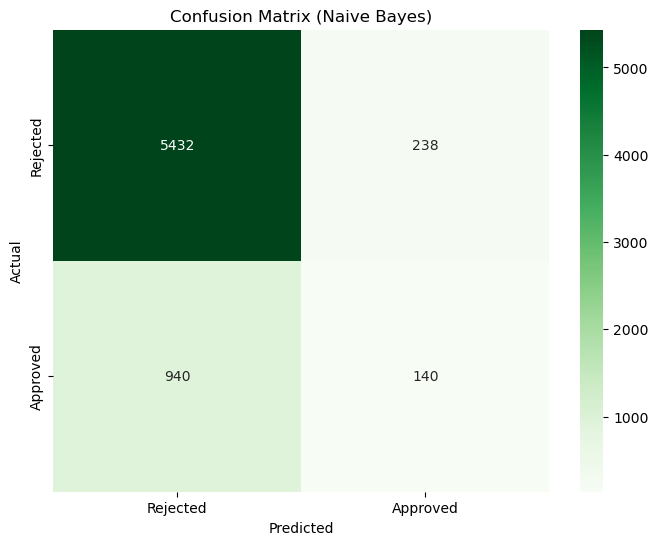


Classification Report (Naive Bayes):
              precision    recall  f1-score   support

       False       0.85      0.96      0.90      5670
        True       0.37      0.13      0.19      1080

    accuracy                           0.83      6750
   macro avg       0.61      0.54      0.55      6750
weighted avg       0.78      0.83      0.79      6750



In [92]:
nb_model = GaussianNB(priors=[0.75, 0.25])
nb_model.fit(X_train, y_train)

y_train_pred = nb_model.predict(X_train)
y_val_pred = nb_model.predict(X_val)

train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

print(f"\nTraining Accuracy (Naive Bayes): {train_accuracy:.4f}")
print(f"Validation Accuracy (Naive Bayes): {val_accuracy:.4f}")

y_test_pred = nb_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy (Naive Bayes): {test_accuracy:.4f}")

conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens", xticklabels=['Rejected', 'Approved'],
           yticklabels=['Rejected', 'Approved'])
plt.title("Confusion Matrix (Naive Bayes)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nClassification Report (Naive Bayes):")
print(classification_report(y_test, y_test_pred, zero_division=1))